In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import RMSprop

In [6]:
!unzip ./Result.zip

Archive:  ./Result.zip
replace Result/{12_(risedronate_sodium_35_MG_Oral_Tablet)_}_Pack/00093-3098-29_NLMIMAGE10_D6436B3B.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
train_dataset = image_dataset_from_directory('./Result', 
                validation_split = 0.2,
                subset= "training",
                seed = 123,
                labels = 'inferred',
                label_mode = 'int',
                image_size = [299, 299],
                interpolation = 'nearest',
                batch_size = 64,
                shuffle=True,
)

Found 4207 files belonging to 2079 classes.
Using 3366 files for training.


In [8]:
val_dataset = train_dataset = image_dataset_from_directory('./Result', 
                validation_split = 0.2,
                subset= "validation",
                seed = 123,
                labels = 'inferred',
                label_mode = 'int',
                image_size = [299, 299],
                interpolation = 'nearest',
                batch_size = 64,
                shuffle=True,
)

Found 4207 files belonging to 2079 classes.
Using 841 files for validation.


In [9]:
class_names = train_dataset.class_names


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

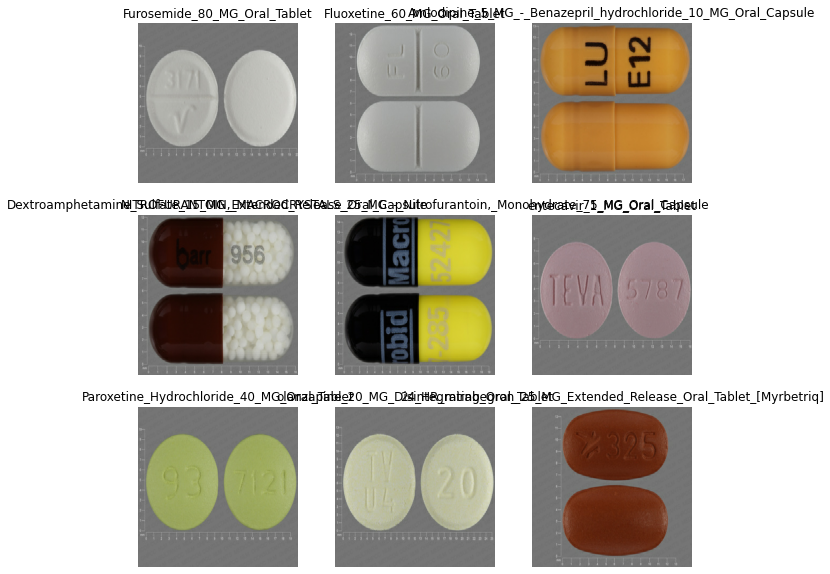

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
pretrained_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/5")
pretrained_model.trainable=False



In [26]:
num_classes = len(class_names)
model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(299, 299, 3)),
        layers.Resizing(299, 299),
        layers.RandomRotation(.2),  
        layers.RandomZoom(.2),
        pretrained_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(.2),
        layers.Dense(num_classes)
        ])
model.build([None, 299, 299, 3])

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [28]:
epochs=30
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/30
14/14 [==============================] - 9s 485ms/step - loss: 7.8888 - accuracy: 0.0024 - val_loss: 6.6234 - val_accuracy: 0.0380
Epoch 2/30
14/14 [==============================] - 6s 432ms/step - loss: 6.4203 - accuracy: 0.0273 - val_loss: 5.4898 - val_accuracy: 0.0642
Epoch 3/30
14/14 [==============================] - 6s 432ms/step - loss: 5.4642 - accuracy: 0.0523 - val_loss: 4.6285 - val_accuracy: 0.1177
Epoch 4/30
14/14 [==============================] - 6s 453ms/step - loss: 4.7025 - accuracy: 0.1094 - val_loss: 4.1309 - val_accuracy: 0.1558
Epoch 5/30
14/14 [==============================] - 6s 440ms/step - loss: 3.9692 - accuracy: 0.1784 - val_loss: 3.5216 - val_accuracy: 0.2414
Epoch 6/30
14/14 [==============================] - 6s 444ms/step - loss: 3.5590 - accuracy: 0.2200 - val_loss: 3.1309 - val_accuracy: 0.2961
Epoch 7/30
14/14 [==============================] - 6s 445ms/step - loss: 3.0922 - accuracy: 0.2747 - val_loss: 2.8224 - val_accuracy: 0.3436
Epoch 

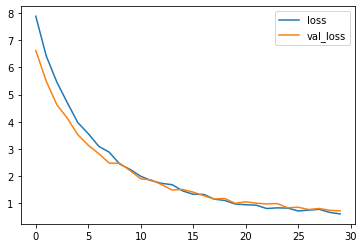

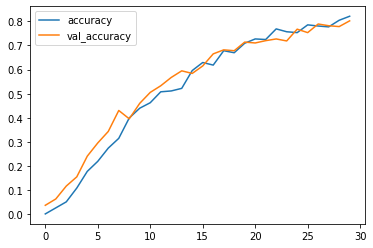

In [29]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();